# Example using scikit-learn

/home/juebrauer/miniconda3/envs/env_teaching/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/juebrauer/miniconda3/envs/env_teaching/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


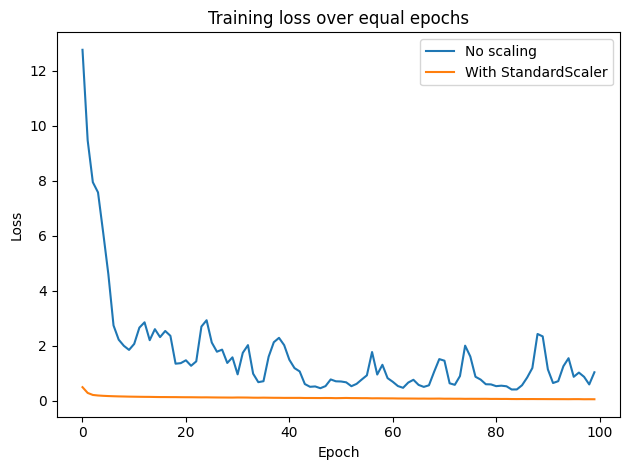

                 Setup  Epochs run  Train accuracy  Test accuracy
0           No scaling         100          0.8768         0.8656
1  With StandardScaler         100          0.9813         0.9504


In [6]:
# Updated demo: Force equal epochs and plot both loss curves together
# - Disables early stopping
# - Fixes max_iter to the same value for both models
# - Plots both loss curves on one figure (no custom colors/styles)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from pathlib import Path

# 1) Synthetic dataset with very different feature scales
RNG = 42
X, y = make_classification(
    n_samples=2500,
    n_features=12,
    n_informative=6,
    n_redundant=2,
    n_repeated=0,
    n_classes=2,
    class_sep=1.4,
    flip_y=0.03,
    random_state=RNG
)

X = X.copy()
X[:, 0] *= 1_000.0
X[:, 1] *= 0.001
X[:, 2] *= 250.0
X[:, 3] *= 0.01

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RNG, stratify=y
)

EPOCHS = 100  # same for both models

def train_mlp_equal_epochs(X_train, y_train, X_test, y_test, use_scaler: bool):
    base_mlp = MLPClassifier(
        hidden_layer_sizes=(50,),
        activation="relu",
        solver="adam",
        learning_rate_init=0.01,
        max_iter=EPOCHS,
        random_state=RNG,
        early_stopping=False,   # ensure no adaptive early stopping
        n_iter_no_change=EPOCHS+1,  # effectively disables "no change" checks even if considered
        tol=0.0,                # make convergence criterion as strict as possible
        verbose=False
    )
    if use_scaler:
        model = Pipeline([("scaler", StandardScaler()), ("mlp", base_mlp)])
        model.fit(X_train, y_train)
        loss_curve = model.named_steps["mlp"].loss_curve_
        y_pred_test = model.predict(X_test)
        y_pred_train = model.predict(X_train)
    else:
        model = base_mlp
        model.fit(X_train, y_train)
        loss_curve = model.loss_curve_
        y_pred_test = model.predict(X_test)
        y_pred_train = model.predict(X_train)

    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)

    # number of epochs actually run (sklearn stores this)
    if use_scaler:
        epochs_run = model.named_steps["mlp"].n_iter_
    else:
        epochs_run = model.n_iter_

    return {
        "model": model,
        "loss_curve": loss_curve,
        "acc_train": acc_train,
        "acc_test": acc_test,
        "epochs_run": epochs_run
    }

# 2) Train
res_ns = train_mlp_equal_epochs(X_train, y_train, X_test, y_test, use_scaler=False)
res_sc = train_mlp_equal_epochs(X_train, y_train, X_test, y_test, use_scaler=True)

# 3) One chart with both loss curves (no manual colors/styles)
plt.figure()
plt.plot(res_ns["loss_curve"], label="No scaling")
plt.plot(res_sc["loss_curve"], label="With StandardScaler")
plt.title("Training loss over equal epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# 4) Results table
summary_df = pd.DataFrame(
    [
        {"Setup": "No scaling", "Epochs run": res_ns["epochs_run"], "Train accuracy": res_ns["acc_train"], "Test accuracy": res_ns["acc_test"]},
        {"Setup": "With StandardScaler", "Epochs run": res_sc["epochs_run"], "Train accuracy": res_sc["acc_train"], "Test accuracy": res_sc["acc_test"]},
    ]
).round(4)

print(summary_df)

# Example using PyTorch

This example shows the training of a MLP for a highly non-linear function ...

... without any scaling of the training data

... with scaling of input data AND no scaling of output data

... with scaling of input data AND with scaling of output data

Output statistics:
  y_train mean: 2650.02, std: 1713.65
  y_train range: [-7550.02, 13127.30]
  y_train_scaled range: [-5.95, 6.11]

Training models for non-linear regression...

1. Training WITHOUT any scaling...

2. Training with INPUT scaling only...

3. Training with BOTH input and output scaling...


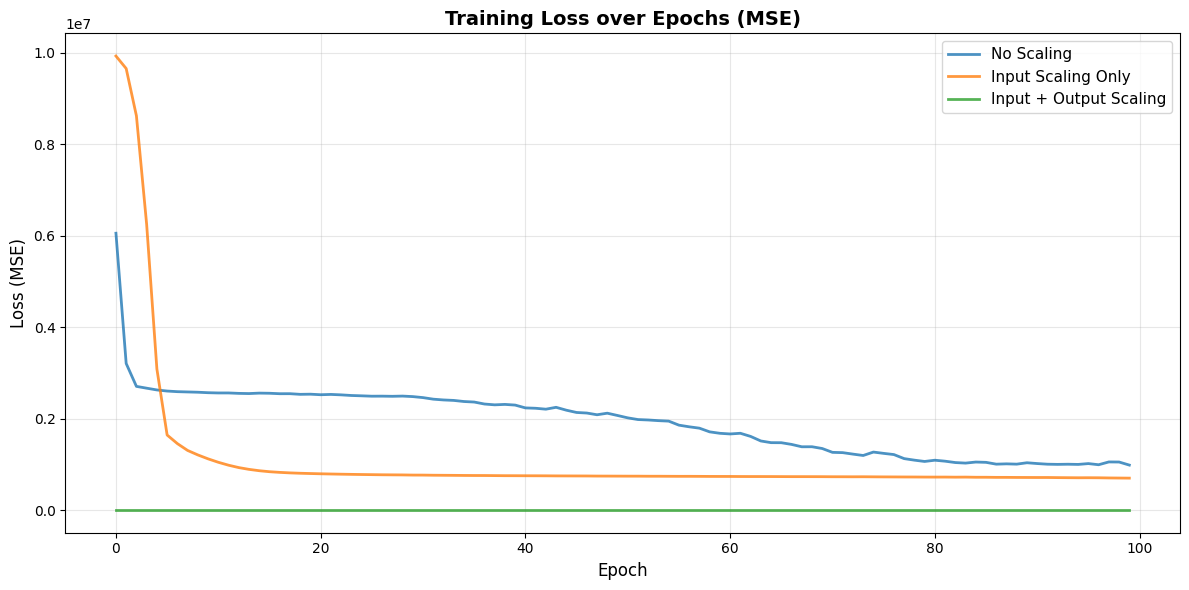

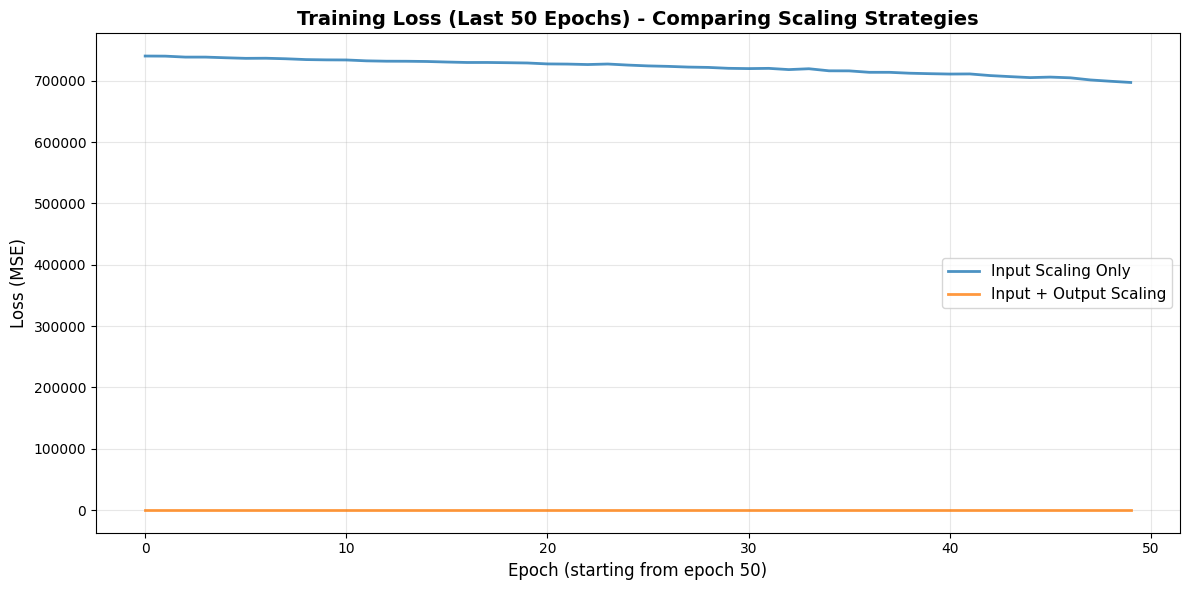

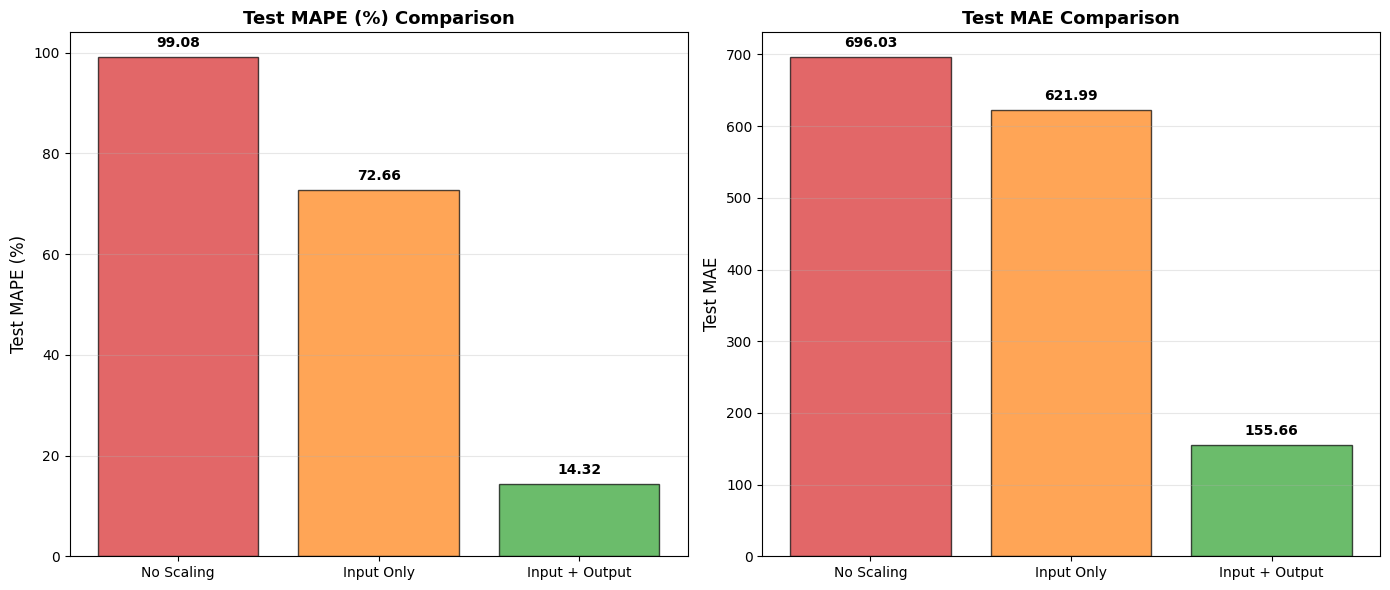


RESULTS SUMMARY
                 Setup  Epochs  Train MAPE (%)  Train MAE  Test MAPE (%)   Test MAE  Final Train Loss
            No Scaling     100      105.993640 678.020813      99.081385 696.025208     982674.656000
    Input Scaling Only     100       85.458463 613.833313      72.661072 621.989990     697410.659367
Input + Output Scaling     100       16.457636 104.842261      14.317109 155.661829          0.007177

IMPROVEMENTS OVER NO SCALING:

Input Scaling Only:
  Test MAPE reduction (abs): 26.4203 pp
  Test MAPE reduction (rel): 26.67%

Input + Output Scaling:
  Test MAPE reduction (abs): 84.7643 pp
  Test MAPE reduction (rel): 85.55%

OUTPUT SCALING ADDITIONAL BENEFIT (over Input-Only):
  Test MAPE reduction (abs): 58.3440 pp
  Test MAPE reduction (rel): 80.30%
  Training loss difference (final epoch): 697410.6522



In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Reproducibility
RNG = 42
np.random.seed(RNG)
torch.manual_seed(RNG)

# 1) Data (Non-Linear Regression)
def generate_nonlinear_data(n_samples=10000, n_features=12, noise=15.0, random_state=42):
    """
    Generate a non-linear regression dataset with various non-linear transformations.
    """
    np.random.seed(random_state)
    
    # Generate random features
    X = np.random.randn(n_samples, n_features)
    
    # Create non-linear target using various transformations
    y = (
        # Polynomial terms
        2.5 * X[:, 0]**2 +
        -1.8 * X[:, 1]**3 +
        # Trigonometric terms
        15.0 * np.sin(X[:, 2]) +
        10.0 * np.cos(X[:, 3]) +
        # Exponential terms
        5.0 * np.exp(X[:, 4] / 3.0) +
        # Interaction terms
        3.0 * X[:, 5] * X[:, 6] +
        # Square root (with absolute value to avoid complex numbers)
        8.0 * np.sqrt(np.abs(X[:, 7])) +
        # Additional polynomial
        -2.0 * X[:, 8]**2 * X[:, 9] +
        # Mixed terms
        4.0 * np.tanh(X[:, 10]) +
        6.0 * X[:, 11]**2
    )

    y *= 100
    
    # Add noise
    y += np.random.normal(0, noise, size=n_samples)
    
    return X, y

X, y = generate_nonlinear_data(
    n_samples=10000,
    n_features=12,
    noise=15.0,
    random_state=RNG
)

# Artificial scale differences to demonstrate the impact of standardization
X = X.copy()
X[:, 0] *= 1000.0
X[:, 1] *= 0.001
X[:, 2] *= 250.0
X[:, 3] *= 0.01
X[:, 4] *= 500.0
X[:, 5] *= 0.005

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RNG
)

def standardize(train, test):
    mean = train.mean(axis=0, keepdims=True)
    std = train.std(axis=0, keepdims=True)
    std[std == 0.0] = 1.0
    return (train - mean) / std, (test - mean) / std

# Input scaling
X_train_scaled, X_test_scaled = standardize(X_train, X_test)

# Output scaling
y_train_mean = y_train.mean()
y_train_std = y_train.std()
y_train_scaled = (y_train - y_train_mean) / y_train_std
y_test_scaled = (y_test - y_train_mean) / y_train_std

print(f"Output statistics:")
print(f"  y_train mean: {y_train_mean:.2f}, std: {y_train_std:.2f}")
print(f"  y_train range: [{y_train.min():.2f}, {y_train.max():.2f}]")
print(f"  y_train_scaled range: [{y_train_scaled.min():.2f}, {y_train_scaled.max():.2f}]\n")

def make_loader(X, y, batch_size=512, shuffle=True):
    X_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.float32)
    ds = TensorDataset(X_t, y_t)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

# Three scenarios
train_loader_raw = make_loader(X_train, y_train)
test_loader_raw  = make_loader(X_test, y_test, shuffle=False)

train_loader_X_scaled = make_loader(X_train_scaled, y_train)
test_loader_X_scaled  = make_loader(X_test_scaled, y_test, shuffle=False)

train_loader_both_scaled = make_loader(X_train_scaled, y_train_scaled)
test_loader_both_scaled  = make_loader(X_test_scaled, y_test_scaled, shuffle=False)

# 2) Model (MLP for Non-Linear Regression)
class MLP(nn.Module):
    def __init__(self, in_dim, hidden1=64, hidden2=32, out_dim=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, out_dim)
        )
    def forward(self, x):
        return self.net(x)  # (N, 1)

def make_model():
    torch.manual_seed(RNG)
    return MLP(in_dim=12)

# 3) Training
def train_model(train_loader, test_loader, epochs=10, lr=1e-2, device="cpu", 
                y_mean=None, y_std=None):
    """
    Train model and evaluate.
    If y_mean and y_std are provided, predictions will be inverse-transformed for evaluation.
    """
    model = make_model().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = nn.MSELoss()

    train_losses = []

    for _ in range(epochs):
        model.train()
        epoch_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            preds = model(xb).squeeze(1)     # (N,)
            loss = crit(preds, yb)           # MSE
            loss.backward()
            opt.step()
            epoch_loss += loss.item() * xb.size(0)
        train_losses.append(epoch_loss / len(train_loader.dataset))

    # Evaluation: MAPE & MAE
    def eval_metrics(loader):
        model.eval()
        ys, yhats = [], []
        with torch.no_grad():
            for xb, yb in loader:
                pred = model(xb.to(device)).squeeze(1).cpu().numpy()
                yhats.append(pred)
                ys.append(yb.numpy())
        y_true = np.concatenate(ys)
        y_pred = np.concatenate(yhats)
        
        # Inverse transform if scaling was applied
        if y_mean is not None and y_std is not None:
            y_true = y_true * y_std + y_mean
            y_pred = y_pred * y_std + y_mean
        
        mape = mean_absolute_percentage_error(y_true, y_pred) * 100.0  # percentage
        mae = mean_absolute_error(y_true, y_pred)
        return mape, mae

    mape_train, mae_train = eval_metrics(train_loader)
    mape_test,  mae_test  = eval_metrics(test_loader)

    return model, train_losses, (mape_train, mae_train), (mape_test, mae_test)

EPOCHS = 100
device = "cpu"

print("Training models for non-linear regression...")
print("=" * 60)

print("\n1. Training WITHOUT any scaling...")
model_raw, loss_raw, (mape_tr_raw, mae_tr_raw), (mape_te_raw, mae_te_raw) = \
    train_model(train_loader_raw, test_loader_raw, epochs=EPOCHS, device=device)

print("\n2. Training with INPUT scaling only...")
model_X_scaled, loss_X_scaled, (mape_tr_X, mae_tr_X), (mape_te_X, mae_te_X) = \
    train_model(train_loader_X_scaled, test_loader_X_scaled, epochs=EPOCHS, device=device)

print("\n3. Training with BOTH input and output scaling...")
model_both_scaled, loss_both_scaled, (mape_tr_both, mae_tr_both), (mape_te_both, mae_te_both) = \
    train_model(train_loader_both_scaled, test_loader_both_scaled, epochs=EPOCHS, 
                device=device, y_mean=y_train_mean, y_std=y_train_std)

# 4) Plots

# Plot 1: Training Loss
plt.figure(figsize=(12, 6))
plt.plot(loss_raw, label="No Scaling", linewidth=2, alpha=0.8)
plt.plot(loss_X_scaled, label="Input Scaling Only", linewidth=2, alpha=0.8)
plt.plot(loss_both_scaled, label="Input + Output Scaling", linewidth=2, alpha=0.8)
plt.title("Training Loss over Epochs (MSE)", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss (MSE)", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Zoomed in on scaled versions (last 50 epochs)
plt.figure(figsize=(12, 6))
plt.plot(loss_X_scaled[-50:], label="Input Scaling Only", linewidth=2, alpha=0.8)
plt.plot(loss_both_scaled[-50:], label="Input + Output Scaling", linewidth=2, alpha=0.8)
plt.title("Training Loss (Last 50 Epochs) - Comparing Scaling Strategies", fontsize=14, fontweight='bold')
plt.xlabel("Epoch (starting from epoch 50)", fontsize=12)
plt.ylabel("Loss (MSE)", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 3: Bar chart comparing final test performance (MAPE & MAE)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

setups = ['No Scaling', 'Input Only', 'Input + Output']
mape_values = [mape_te_raw, mape_te_X, mape_te_both]
mae_values = [mae_te_raw, mae_te_X, mae_te_both]

colors = ['#d62728', '#ff7f0e', '#2ca02c']

ax1.bar(setups, mape_values, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Test MAPE (%)', fontsize=12)
ax1.set_title('Test MAPE (%) Comparison', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(mape_values):
    ax1.text(i, v + max(mape_values)*0.02, f'{v:.2f}', ha='center', fontsize=10, fontweight='bold')

ax2.bar(setups, mae_values, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Test MAE', fontsize=12)
ax2.set_title('Test MAE Comparison', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(mae_values):
    ax2.text(i, v + max(mae_values)*0.02, f'{v:.2f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# 5) Summary
print("\n" + "=" * 60)
print("RESULTS SUMMARY")
print("=" * 60)

summary = pd.DataFrame([
    {
        "Setup": "No Scaling",
        "Epochs": EPOCHS,
        "Train MAPE (%)": mape_tr_raw,
        "Train MAE": mae_tr_raw,
        "Test MAPE (%)": mape_te_raw,
        "Test MAE": mae_te_raw,
        "Final Train Loss": loss_raw[-1]
    },
    {
        "Setup": "Input Scaling Only",
        "Epochs": EPOCHS,
        "Train MAPE (%)": mape_tr_X,
        "Train MAE": mae_tr_X,
        "Test MAPE (%)": mape_te_X,
        "Test MAE": mae_te_X,
        "Final Train Loss": loss_X_scaled[-1]
    },
    {
        "Setup": "Input + Output Scaling",
        "Epochs": EPOCHS,
        "Train MAPE (%)": mape_tr_both,
        "Train MAE": mae_tr_both,
        "Test MAPE (%)": mape_te_both,
        "Test MAE": mae_te_both,
        "Final Train Loss": loss_both_scaled[-1]
    },
])

print(summary.to_string(index=False))
print("\n" + "=" * 60)
print("IMPROVEMENTS OVER NO SCALING:")
print("=" * 60)

print(f"\nInput Scaling Only:")
print(f"  Test MAPE reduction (abs): {mape_te_raw - mape_te_X:.4f} pp")
print(f"  Test MAPE reduction (rel): {((mape_te_raw - mape_te_X) / mape_te_raw * 100):.2f}%")

print(f"\nInput + Output Scaling:")
print(f"  Test MAPE reduction (abs): {mape_te_raw - mape_te_both:.4f} pp")
print(f"  Test MAPE reduction (rel): {((mape_te_raw - mape_te_both) / mape_te_raw * 100):.2f}%")

print(f"\n" + "=" * 60)
print("OUTPUT SCALING ADDITIONAL BENEFIT (over Input-Only):")
print("=" * 60)
print(f"  Test MAPE reduction (abs): {mape_te_X - mape_te_both:.4f} pp")
print(f"  Test MAPE reduction (rel): {((mape_te_X - mape_te_both) / mape_te_X * 100):.2f}%")
print(f"  Training loss difference (final epoch): {loss_X_scaled[-1] - loss_both_scaled[-1]:.4f}")

print("\n" + "=" * 60)


In [20]:
X.shape

(10000, 12)

In [21]:
X[:5]

array([[ 4.96714153e+02, -1.38264301e-04,  1.61922135e+02,
         1.52302986e-02, -1.17076687e+02, -1.17068478e-03,
         1.57921282e+00,  7.67434729e-01, -4.69474386e-01,
         5.42560044e-01, -4.63417693e-01, -4.65729754e-01],
       [ 2.41962272e+02, -1.91328024e-03, -4.31229458e+02,
        -5.62287529e-03, -5.06415560e+02,  1.57123666e-03,
        -9.08024076e-01, -1.41230370e+00,  1.46564877e+00,
        -2.25776300e-01,  6.75282047e-02, -1.42474819e+00],
       [-5.44382725e+02,  1.10922590e-04, -2.87748394e+02,
         3.75698018e-03, -3.00319345e+02, -1.45846875e-03,
        -6.01706612e-01,  1.85227818e+00, -1.34972247e-02,
        -1.05771093e+00,  8.22544912e-01, -1.22084365e+00],
       [ 2.08863595e+02, -1.95967012e-03, -3.32046512e+02,
         1.96861236e-03,  3.69233290e+02,  8.56841406e-04,
        -1.15648282e-01, -3.01103696e-01, -1.47852199e+00,
        -7.19844208e-01, -4.60638771e-01,  1.05712223e+00],
       [ 3.43618290e+02, -1.76304016e-03,  8.1020992

In [22]:
y.shape

(10000,)

In [23]:
y

array([16.72386245, 37.77322197, 34.52668112, ..., 30.23586234,
       12.96673053, 48.73908566])